In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/DATA SCIENTIST/P8')

#Librairies

In [ ]:
pip install pyspark

     |████████████████████████████████| 212.3MB 68kB/s 
     |████████████████████████████████| 204kB 19.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=3824b8da3993457f0b17e1b83d2521e68dc5a6cccf5984ea2dd8ef7d831d87ba
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
pip install sparkDL

In [ ]:
pip install boto3

     |████████████████████████████████| 133kB 5.2MB/s 
     |████████████████████████████████| 71kB 3.8MB/s 
     |████████████████████████████████| 7.3MB 6.8MB/s 
     |████████████████████████████████| 153kB 41.0MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
# Librairies
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
 
# image
from PIL import Image,ImageOps,ImageFilter
 
# S3 AWS
import boto3
 
# spark
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import udf
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.sql.types import ArrayType, StringType, IntegerType, DoubleType, DataType, FloatType

#imports pour l'extraction des features
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

from pyspark.sql.functions import col, pandas_udf, PandasUDFType

#EDA

### Vue d'ensemble

In [ ]:
train_categories = []
train_samples = []
for i in os.listdir("Training/"):
    train_categories.append(i)
    train_samples.append(len(os.listdir("Training/"+ i)))

test_categories = []
test_samples = []
for i in os.listdir("Test/"):
    test_categories.append(i)
    test_samples.append(len(os.listdir("Test/"+ i)))


In [ ]:
train_set=pd.DataFrame()
train_set['Catego']=train_categories
train_set['nb_pic']=train_samples

test_set=pd.DataFrame()
test_set['Catego']=test_categories
test_set['nb_pic']=test_samples

train_set.head()

,Catego,nb_pic
0,Apple Braeburn,492
1,Apple Crimson Snow,444
2,Apple Golden 1,480
3,Apple Golden 2,492
4,Apple Red 1,492


In [ ]:
#nb de catégorie
print('nb de catégorie dans le train :', train_set['Catego'].nunique())
print('nb d\'images dans le train :',train_set['nb_pic'].sum())
print('#'*45)
print('nb de catégorie dans le test :', test_set['Catego'].nunique())
print('nb d\'images dans le test :',test_set['nb_pic'].sum())


nb de catégorie dans le train : 131
nb d'images dans le train : 67694
#############################################
nb de catégorie dans le test : 131
nb d'images dans le test : 22687


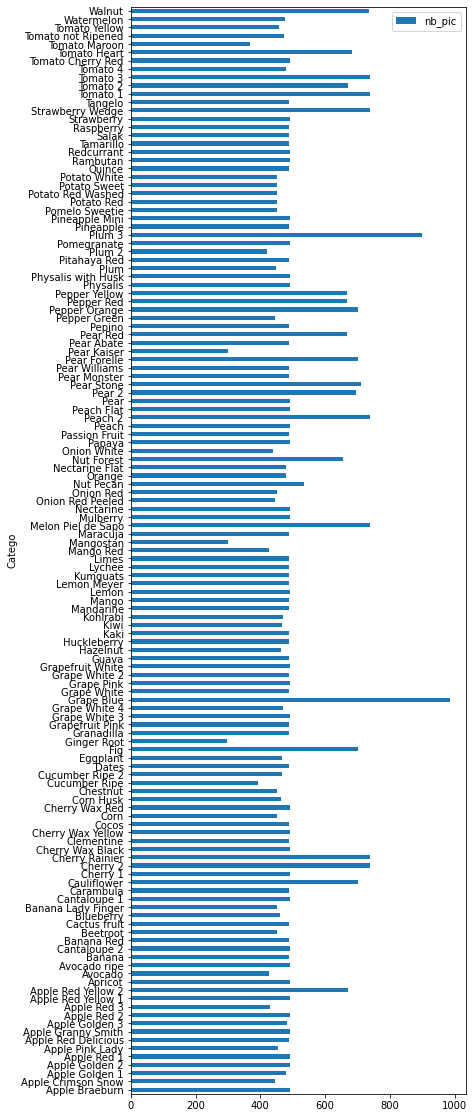

In [ ]:
train_set.plot.barh(x='Catego', y='nb_pic', figsize=(6,20))

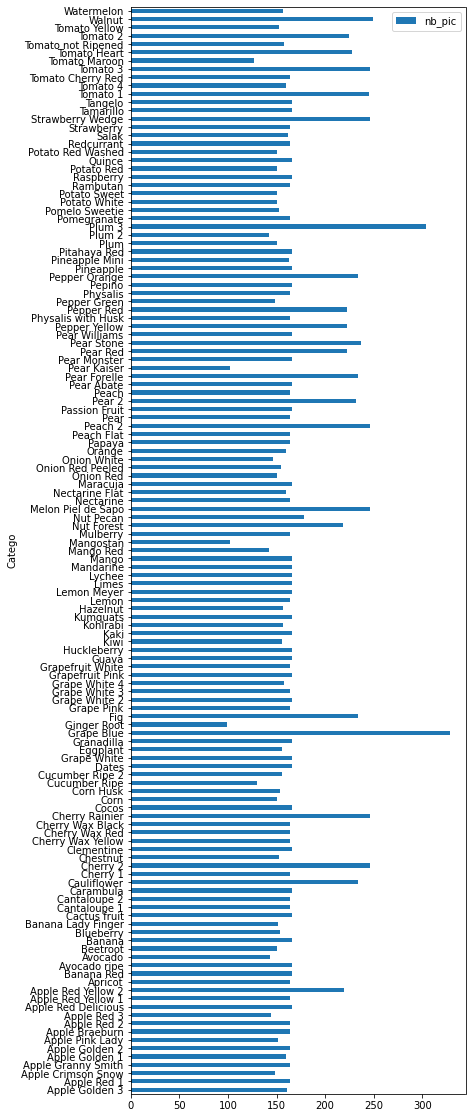

In [ ]:
test_set.plot.barh(x='Catego', y='nb_pic', figsize=(6,20))

In [ ]:
train_set['nb_pic'].sum()

67694

### Traitement image

Largeur : 100 px, hauteur : 100 px


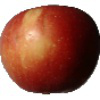

In [ ]:
# Exemple image
img = Image.open("0_100.jpg") 

# Récupérer et afficher la taille de l'image (en pixels)
w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

img

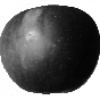

In [ ]:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
Image.fromarray(img_gray)

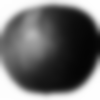

In [ ]:
img_bruit = gaussian_filter(img_gray, sigma=3)
Image.fromarray(img_bruit)

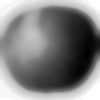

In [ ]:
img_egal=cv2.equalizeHist(img_bruit)
Image.fromarray(img_egal)

In [ ]:
img_siz = cv2.resize(img_egal, dsize=(20,20))
Image.fromarray(img_siz)

#FONCTIONS

In [ ]:
### Connexion au S3

def connexion_S3(S3=True):

  '''Connexion au cloud S3 à partir des ID du fichier key_s3.txt'''
  
  if S3==True:
    #connexion S3 
    key=open('key_s3.txt','r')
    wrd=key.read()
    ID=str(wrd).split('\n')[0]
    PW=str(wrd).split('\n')[1]
 
    session = boto3.session.Session(aws_access_key_id=ID,aws_secret_access_key=PW)
    s3_client = session.client(service_name='s3', region_name="eu-west-3")
    bucket = s3_client.list_objects_v2(Bucket="jbdenisbucket", Prefix='S3_train')
    s3 = boto3.resource('s3',
                      aws_access_key_id=ID,
                      aws_secret_access_key=PW)
 
    return s3_client ,bucket, s3


### Création du RDD avec chemin vers les images
def get_path ():
  
 
    #récupération liste de chemin des images
  path_list=[]
  for i in bucket['Contents']:
    path_list.append(i['Key'])
 
  print('Nombres d\'images :',len(path_list))
 
  # RDD depuis la path_list
  rdd = sc.parallelize(path_list)
  row_rdd = rdd.map(lambda x: Row(x))
  df = spark.createDataFrame(row_rdd, ["path_img"])
  return df
 
### Extraction des catégories
def get_catego (path):
  list_file = path.split("/")
  catego = list_file[-2]
  return catego
 
### Process image
def preprocess(image):
 
    key=open('key_s3.txt','r')
    wrd=key.read()
    ID=str(wrd).split('\n')[0]
    PW=str(wrd).split('\n')[1]
  
    #récupération des images
    s3 = boto3.resource('s3',
                        aws_access_key_id=ID,
                        aws_secret_access_key=PW)
    
    obj = s3.Object(bucket_name='jbdenisbucket', key=image)
    response = obj.get()
    stream = response['Body']
     
    img = Image.open(stream).resize([20, 20])    
    im2 = ImageOps.equalize(img, mask = None) 
    im3=im2.filter(ImageFilter.GaussianBlur(radius=1))
    return preprocess_input(img_to_array(im3))
  
def model_features():
 
    model = EfficientNetB0(weights=None, include_top=False,pooling='avg')
    model.set_weights(weights.value)
    return model
 
### Extraction des features
def featurize_images(model,images_series):
 
    entree = np.stack(images_series.map(preprocess))
    preds = model.predict(entree)
 
    sortie = [p.flatten() for p in preds]
 
    return pd.Series(sortie)
 
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def udf_featurizer(series_images):
 
    model = model_features()
    for images in series_images:
        yield featurize_images(model, images)  
 
### Réduction dimensionnelle des images
def reduction_dimension(df):
 
    # Les données images sont converties au format vecteur dense
    ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
    df = df.withColumn('features', ud_f('features'))
    
    # Mise à l'échelle
    standardizer = StandardScaler(inputCol="features", outputCol="feat_scal",withStd=True, withMean=True)
    model_std = standardizer.fit(df)
    df = model_std.transform(df)
 
    # Recherche nb de composante
    num_components = 1000
    pca = PCA(k = num_components,
            inputCol="feat_scal", 
              outputCol="features_pca")
 
    reduc = pca.fit(df)
    variance = reduc.explainedVariance
 
    # visuel
    plt.plot(np.arange(len(variance))+1, variance.cumsum(),c="red",marker='o')
    plt.xlabel("Nb de composantes")
    plt.ylabel("% variance")
    plt.show(block=False)
 
    def nb_comp ():
      for i in range(500):
          a = variance.cumsum()[i]
          if a >= 0.95:
              print("{} composantes principales expliquent au moins 95% de la variance totale".format(i))
              break
      return i
 
    n_comp=nb_comp()
 
    # Réduction de dimention
    pca = PCA(k=n_comp, inputCol='feat_scal', outputCol='feat_reduit')
    model_pca = pca.fit(df)
    df = model_pca.transform(df)
 
    return df  
 
### Upload sur S3
def upload_s3(df):
 
  df_csv=df.toPandas()
  csv_buffer = StringIO()
  df_csv.to_csv(csv_buffer)
 
  s3_client.put_object(Body=csv_buffer.getvalue(),Bucket="jbdenisbucket",Key='result/df')
  
### Download depuis S3
def download_s3 (key_name):  
  obj = s3.Object(bucket_name='jbdenisbucket', key=key_name)
  response = obj.get()
  stream = response['Body']
 
  df_parquet=pd.read_csv(stream)
  df_parquet_reduit=df_parquet.drop(['Unnamed: 0','features','feat_scal'],axis=1)
  return df_parquet_reduit

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


#EXECUTION

----Connexion au cloud S3----
##############################
----Extraction de la liste d'images----
Nombres d'images : 1000
##############################
----Extraction des catégories----
##############################
----Extraction des features----
##############################
----Réduction dimensionnelle----


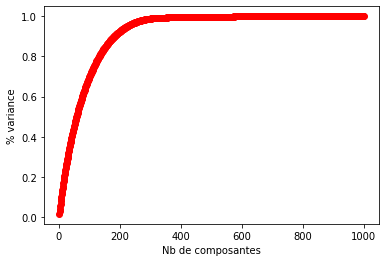

223 composantes principales expliquent au moins 95% de la variance totale
##############################
----Apperçu des 10 premiers élements----
+--------------------+--------------+--------------------+--------------------+--------------------+
|            path_img|        catego|            features|           feat_scal|         feat_reduit|
+--------------------+--------------+--------------------+--------------------+--------------------+
|S3_train/Apple Br...|Apple Braeburn|[-0.1886730641126...|[-0.7168489172418...|[0.99454137005385...|
|S3_train/Apple Br...|Apple Braeburn|[-0.1512335240840...|[-0.3478753132488...|[28.5323323925517...|
|S3_train/Apple Br...|Apple Braeburn|[-0.1388882845640...|[-0.2262106903822...|[18.9709912379284...|
|S3_train/Apple Br...|Apple Braeburn|[-0.1600339561700...|[-0.4346052020505...|[-2.5992479202544...|
|S3_train/Apple Br...|Apple Braeburn|[-0.1962399631738...|[-0.7914221095281...|[-9.5811251528302...|
|S3_train/Apple Br...|Apple Braeburn|[-0.14759

In [ ]:
# Connexion S3
print('----Connexion au cloud S3----')
s3_client ,bucket, s3=connexion_S3(S3=True)
print('#'*30)
 
# Lancement session spark
sc = SparkContext.getOrCreate()
sc.setLogLevel('WARN')
spark = SparkSession.builder.appName("P8").getOrCreate()
 
# RDD
print('----Extraction de la liste d\'images----')
df=get_path()
print('#'*30)
 
# Extraction catégorie
print('----Extraction des catégories----')
udf_categ = udf(get_catego, StringType())
df = df.withColumn("catego", udf_categ('path_img'))
print('#'*30)
 
# Process images
print('----Extraction des features----')

### Transfert learning    
model = EfficientNetB0(weights='imagenet',include_top=False)
weights = sc.broadcast(model.get_weights())

df = df.repartition(3).select(col("path_img"),col("catego"), udf_featurizer("path_img").alias("features"))
print('#'*30)
 
# ACP
print('----Réduction dimensionnelle----')
df = reduction_dimension(df)
print('#'*30)
 
# Show
print('----Apperçu des 10 premiers élements----')
df.show(10)
print('#'*30)
 
# Up
print('----Enregistrement sur le cloud----')
upload_s3(df)
print('Save on S3 done.')
print('#'*30)

#RECUPERATION

In [ ]:
# Down
df=download_s3 ('result/df') 
df.head()

,path_img,catego,feat_reduit
0,S3_train/Apple Braeburn/124_100.jpg,Apple Braeburn,"[0.9945413700538509,-0.1819554545041585,-12.47..."
1,S3_train/Apple Braeburn/r_141_100.jpg,Apple Braeburn,"[28.532332392551748,-0.14957640954728985,15.37..."
2,S3_train/Apple Braeburn/r_291_100.jpg,Apple Braeburn,"[18.97099123792841,0.041526324637720116,-7.658..."
3,S3_train/Apple Braeburn/r_246_100.jpg,Apple Braeburn,"[-2.5992479202544243,0.05583728843470907,-12.5..."
4,S3_train/Apple Braeburn/250_100.jpg,Apple Braeburn,"[-9.581125152830287,0.0008866971568593368,4.28..."
